# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Kenza Driss*
* *Maximilien Hoffbeck*
* *Jaeyi Jeong*
* *Yoojin Kim*
---

#### Instructions

*This is a template for part 2 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.2 Network sampling

#### Exercise 2.7: Random walk on the Facebook network

In [1]:
import requests
import random

In [2]:
# Base URL of the API
HOSTNAME = 'http://iccluster031.iccluster.epfl.ch'
URL_TEMPLATE = HOSTNAME + ':5050/v1.0/facebook?user={user_id}'

# Starting node
start_node = 'a5771bce93e200c36f7cd9dfd0e5deaa'

N = 1000 # Number of nodes to visit (we choose N = 1000 for a reasonable sample size)
current_node = start_node
ages = []
degrees = []
visited_count = 0

# Perform the random walk
while visited_count < N:
    # Query the API for the current node
    url = URL_TEMPLATE.format(user_id=current_node)
    response = requests.get(url)
    data = response.json()
    
    # Extract the age and friends
    age = data['age']
    friends = data['friends']
    
    # Add the age to our list
    ages.append(age)
    
    # Select a random neighbor
    if friends:  # Ensure the node has friends to avoid errors
        current_node = random.choice(friends)
    else:
        # If no friends, restart from the starting node
        current_node = start_node
    
    visited_count += 1

# Calculate the average age
average_age = sum(ages) / len(ages)

# Output the results
print(f"Number of users visited: {visited_count}")
print(f"Estimated average age: {average_age:.2f}")

Number of users visited: 1000
Estimated average age: 21.16


#### Exercise 2.8

The estimation we obtained is significantly lower than the actual average, around less than a half.

Several factors could explain this discrepancy:

### Bias in Random Walk Sampling:
A random walk tends to oversample nodes with high degrees because nodes with more friends are more likely to be visited. If younger users have more friends (for example by being more active on social media), the random walk will visit them more often, pulling the average age downward.

### Non-Uniform Age Distribution:
The age distribution on Facebook may not be uniform. If younger users form a large, densely connected component, the random walk might get “trapped” in this subgraph, rarely visiting older users who may have fewer connections or be in a different part of the network.

### Starting Node Bias:
The starting node **"a5771bce93e200c36f7cd9dfd0e5deaa"** might be a younger user or part of a younger user community, causing the random walk to initially sample a biased subset of the network. Random walks can take a long time to “mix” and explore the entire graph, especially in large, clustered networks like social networks.

### Burn-in Period:
The random walk may not have reached a stationary distribution within 1000 steps, which is a value we chose to have a reasonable running time. The initial steps (burn-in period) are heavily influenced by the starting node’s neighborhood, which may not be representative of the entire network.

To improve the estimate without crawling more users or using additional seeds, we could re-evaluate the weights of each node to adjust for the oversampling of high-degree nodes.

We can try to weight each node’s age by the inverse of its degree (number of friends), since high-degree nodes are visited more often. The corrected average age can be estimated as:

$$
\text{Corrected average age} = \frac{\sum_{i \in \text{visited nodes}} \text{age}_i / \text{degree}_i}{\sum_{i \in \text{visited nodes}} 1 / \text{degree}_i}
$$
 
However, since we visit nodes multiple times in a random walk, we need to account for the frequency of visits: let's weight each visit by the inverse of the node’s degree.

In [3]:
# Base URL of the API
HOSTNAME = 'http://iccluster031.iccluster.epfl.ch'
URL_TEMPLATE = HOSTNAME + ':5050/v1.0/facebook?user={user_id}'

# Starting node
start_node = 'a5771bce93e200c36f7cd9dfd0e5deaa'

N = 1000
current_node = start_node
ages = []
degrees = []
visited_count = 0

# Perform the random walk and collect ages and degrees
while visited_count < N:
    url = URL_TEMPLATE.format(user_id=current_node)
    response = requests.get(url)
    data = response.json()
    
    age = data['age']
    friends = data['friends']
    degree = len(friends)
    
    ages.append(age)
    degrees.append(degree)
    
    if friends:
        current_node = random.choice(friends)
    else:
        current_node = start_node
    
    visited_count += 1

# Compute the naive average
naive_average = sum(ages) / len(ages)

# Compute the corrected average by weighting by inverse degree
# For each visit, weight the age by 1/degree
weighted_sum = 0
weight_sum = 0
for age, degree in zip(ages, degrees):
    if degree > 0:
        weight = 1 / degree
        weighted_sum += age * weight
        weight_sum += weight

corrected_average = weighted_sum / weight_sum if weight_sum > 0 else 0

# Output results
print(f"Naive average age: {naive_average:.2f}")
print(f"Corrected average age: {corrected_average:.2f}")

Naive average age: 25.36
Corrected average age: 46.53


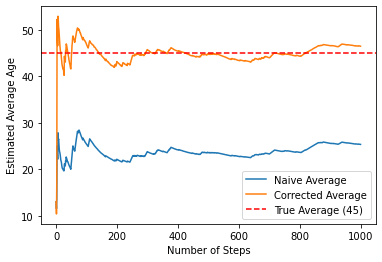

In [4]:
import matplotlib.pyplot as plt

running_naive = []
running_corrected = []
current_sum = 0
current_weighted_sum = 0
current_weight_sum = 0

for i, (age, degree) in enumerate(zip(ages, degrees)):
    current_sum += age
    running_naive.append(current_sum / (i + 1))
    
    if degree > 0:
        weight = 1 / degree
        current_weighted_sum += age * weight
        current_weight_sum += weight
        running_corrected.append(current_weighted_sum / current_weight_sum)
    else:
        running_corrected.append(running_corrected[-1] if running_corrected else 0)

# Plot
plt.plot(running_naive, label='Naive Average')
plt.plot(running_corrected, label='Corrected Average')
plt.axhline(y=45, color='r', linestyle='--', label='True Average (45)')
plt.xlabel('Number of Steps')
plt.ylabel('Estimated Average Age')
plt.legend()
plt.show()